In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import os
import itertools
import scipy.stats as stats

In [2]:
data_path = "/csv/"
cwd = os.getcwd()
files = [f for f in os.listdir(cwd+data_path) if os.path.isfile(f)==False and f not in []] #add "t1.csv" in empty ls t remove first measurement

In [3]:
def calculate_rwc(dw, hw, fw):
    return ((fw-dw)/(hw-dw))

def calculate_real_dw(dw, aluw):
    return dw-aluw

def calculate_rwc_from_row(row):
    fresh_weight = float(row[3])
    rehydrated_weight = float(row[4])
    alu_weight = float(row[2]) - rehydrated_weight
    dry_weight = calculate_real_dw(float(row[5]), alu_weight)
    return calculate_rwc(dry_weight, rehydrated_weight, fresh_weight)

def n2k(name): #name to key
    first_l = name[0]
    if len(name)>3:
        return "CTRL"
    elif first_l == "C":
        return "CA"
    elif first_l == "R":
        return "RE"
    elif first_l == "H":
        return "HQ"
    
def tp2t(timepoint): #timepoint to time
    number = int(timepoint[1])
    if number == 1:
        return 3
    elif number == 2:
        return 6
    elif number == 3:
        return 24
    elif number == 4:
        return 27
    elif number == 5:
        return 30
    
def t2tp(number): #time to timepoint
    if number == 3:
        return "t1"
    elif number == 6:
        return "t2"
    elif number == 24:
        return "t3"
    elif number == 27:
        return "t4"
    elif number == 30:
        return "t5"
    
def sort_by_ascending_time(time, *args): #returns tuple with sorted lists
    sorted_time = sorted(time)
    transform = [None]*len(time)
    ret = [sorted_time]
    for idx, n in enumerate(sorted_time):
        transform[time.index(n)]=idx#
    for lst in args:
        new_lst = [None]*len(time)
        for idx, n in enumerate(lst):
            new_lst[transform[idx]] = n
        ret.append(new_lst)
    return tuple(ret)

In [4]:
rwc_datapoints = {"CA": {}, "RE": {}, "HQ": {}, "CTRL": {}}
cols=["b", "g", "r", "k"]
for file in files:
    timepoint = file.split(".")[0]
    with open(cwd+data_path+file) as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        next(reader)
        for row in reader:
            name = row[0]
            rwc = calculate_rwc_from_row(row)
            try:
                len(rwc_datapoints[n2k(name)][timepoint])
                rwc_datapoints[n2k(name)][timepoint].append(rwc)
            except:
                rwc_datapoints[n2k(name)][timepoint] = [rwc]

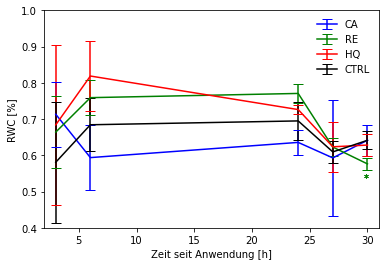

In [5]:
fig, ax = plt.subplots(1,1)
cols=["b", "g", "r", "k"]
col_idx=0
ax.set_xlim([2, 31])
ax.set_xlabel("Zeit seit Anwendung [h]")
ax.set_ylabel("RWC [%]")
ax.set_ylim([0.4,1.0])
for substance, val in rwc_datapoints.items():
    _rwc = [np.mean(rwcs) for _, rwcs in val.items()]
    _err = [np.std(rwcs, ddof=0) for _, rwcs in val.items()]
    _t = [tp2t(key) for key, _ in val.items()]
    t,rwc,err = sort_by_ascending_time(_t, _rwc, _err)
    ax.errorbar(t, rwc, label=substance, yerr=err,capsize=5, fmt=cols[col_idx])
    col_idx+=1
    lgd=ax.legend(frameon=False)
    ax.annotate("*", (29.7,0.53), c="g") #p=0.0133
fig.savefig("figure_german.png", dpi=500, bbox_extra_artists=(lgd))

# Statistics

In [6]:
for substance, val in rwc_datapoints.items():
    print("\n\n"+ substance)
    for time, rwcs in val.items():
        ctrl = rwc_datapoints["CTRL"][time]
        res2 = stats.ttest_ind_from_stats(np.mean(rwcs), np.std(rwcs), 3, np.mean(ctrl), np.std(ctrl), 3, equal_var=False)
        print(time+ f" {round(res2.pvalue/2, 4)}")



CA
t3 0.0929
t2 0.1259
t1 0.1552
t5 0.4979
t4 0.4379


RE
t3 0.0549
t2 0.1123
t1 0.2536
t5 0.0133
t4 0.292


HQ
t3 0.203
t2 0.0668
t1 0.2776
t5 0.2946
t4 0.3839


CTRL
t3 0.5
t2 0.5
t1 0.5
t5 0.5
t4 0.5
